In [1]:
import cv2
import glob
import numpy as np
from matplotlib import pyplot as plt
from skimage import feature ,exposure
from skimage.feature import hog
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.naive_bayes import GaussianNB 
from sklearn.tree import DecisionTreeClassifier    
from sklearn.svm import SVC 
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn import preprocessing
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import sklearn.cluster as cluster
import time
import hdbscan

In [2]:
df = pd.read_csv("leaves.csv")
df.drop_duplicates(inplace=True)
X= df.drop(columns=df.columns[0])
Y = df[df.columns[0]]
scaler = preprocessing.MinMaxScaler()
# X=scaler.fit_transform(X)


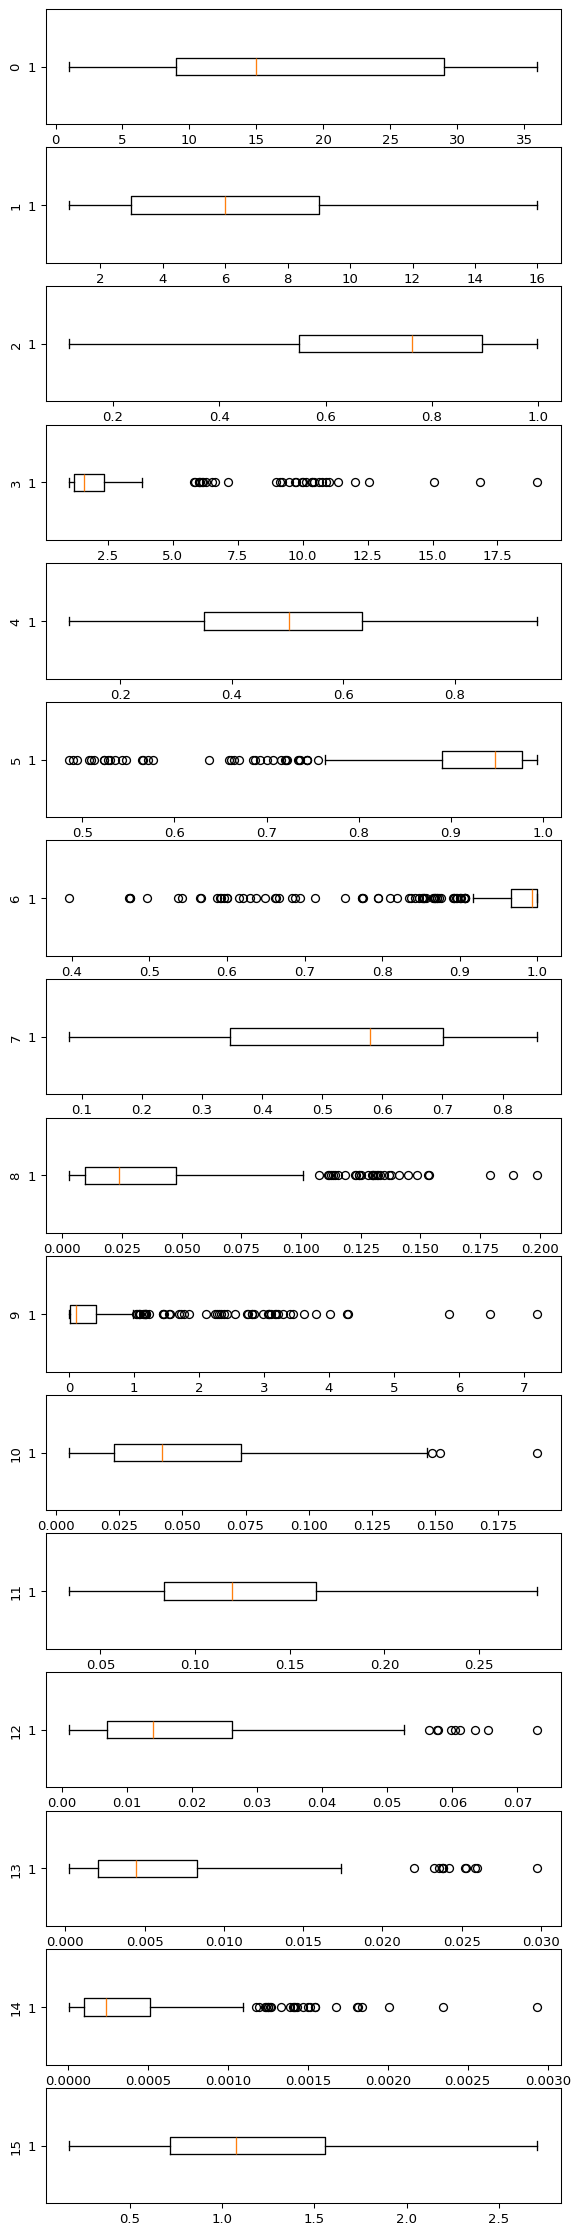

In [3]:
fig, axs = plt.subplots(16,1,dpi=95, figsize=(7,30))
i = 0
for col in df.columns:
    axs[i].boxplot(df[col], vert=False)
    axs[i].set_ylabel(col)
    i+=1
plt.show()

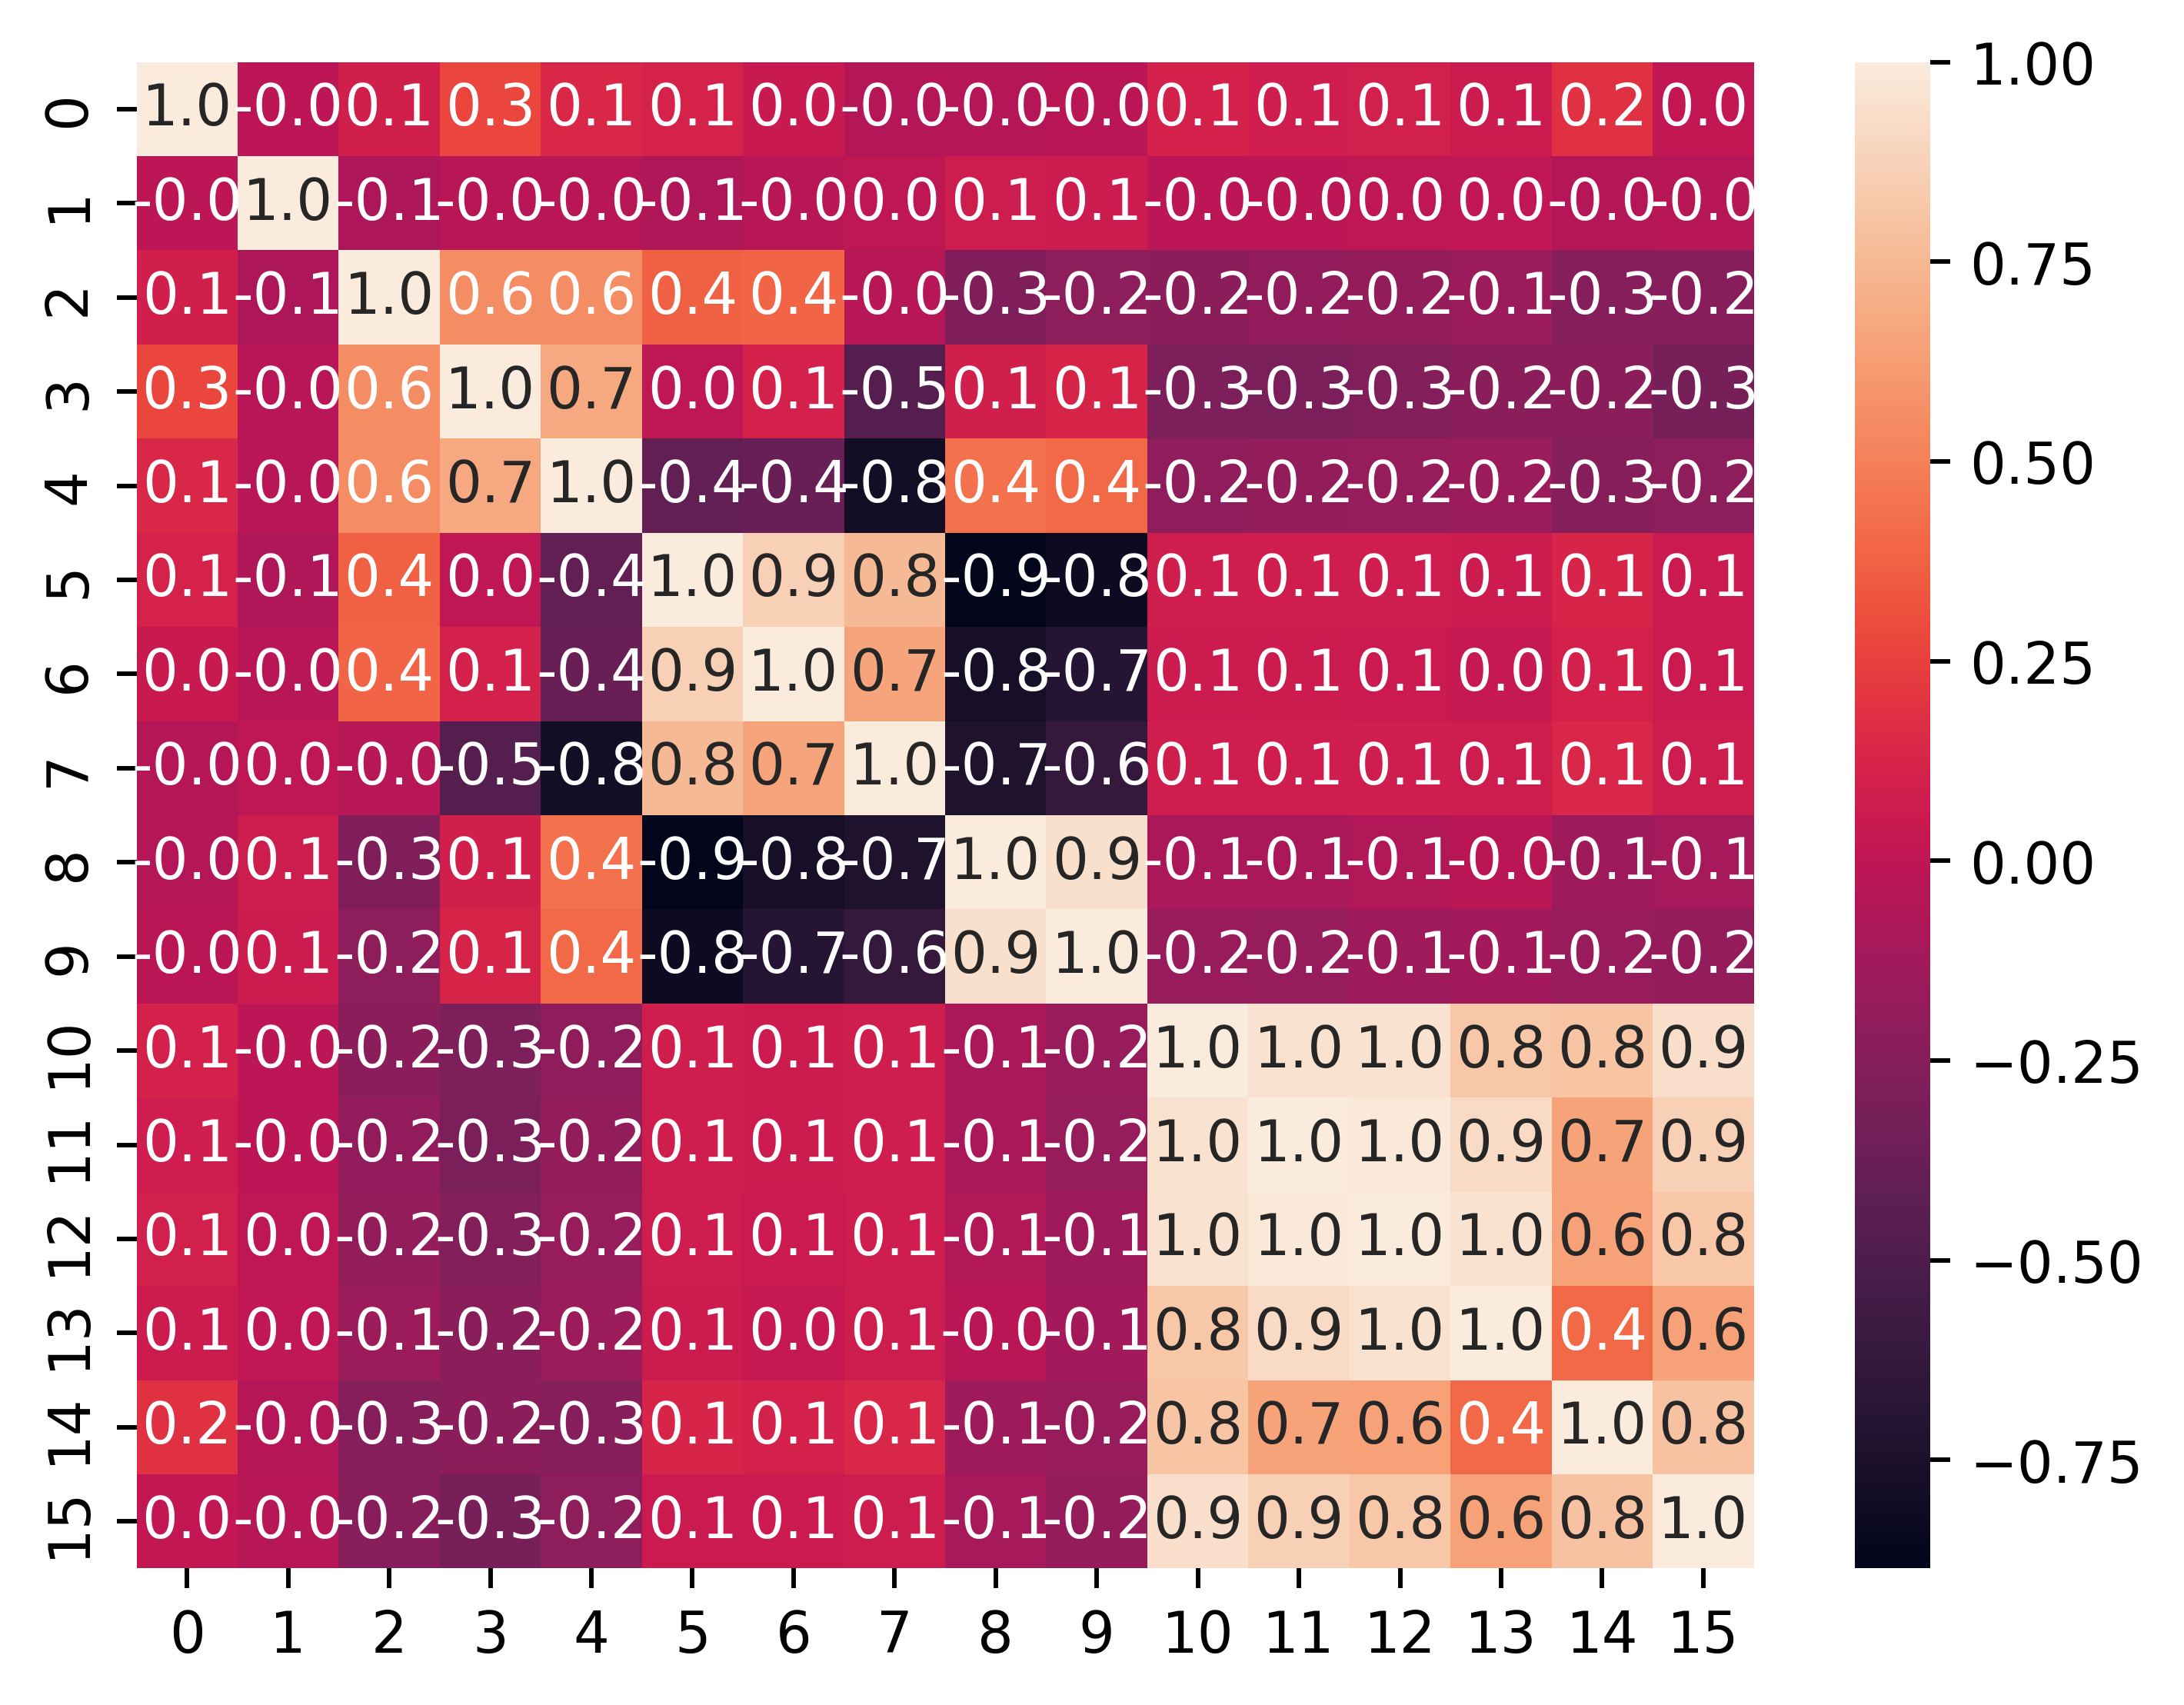

In [4]:
#correlation
corr = df.corr()
plt.figure(dpi=530)
sns.heatmap(df.corr(), annot=True, fmt= '.1f')
plt.show()


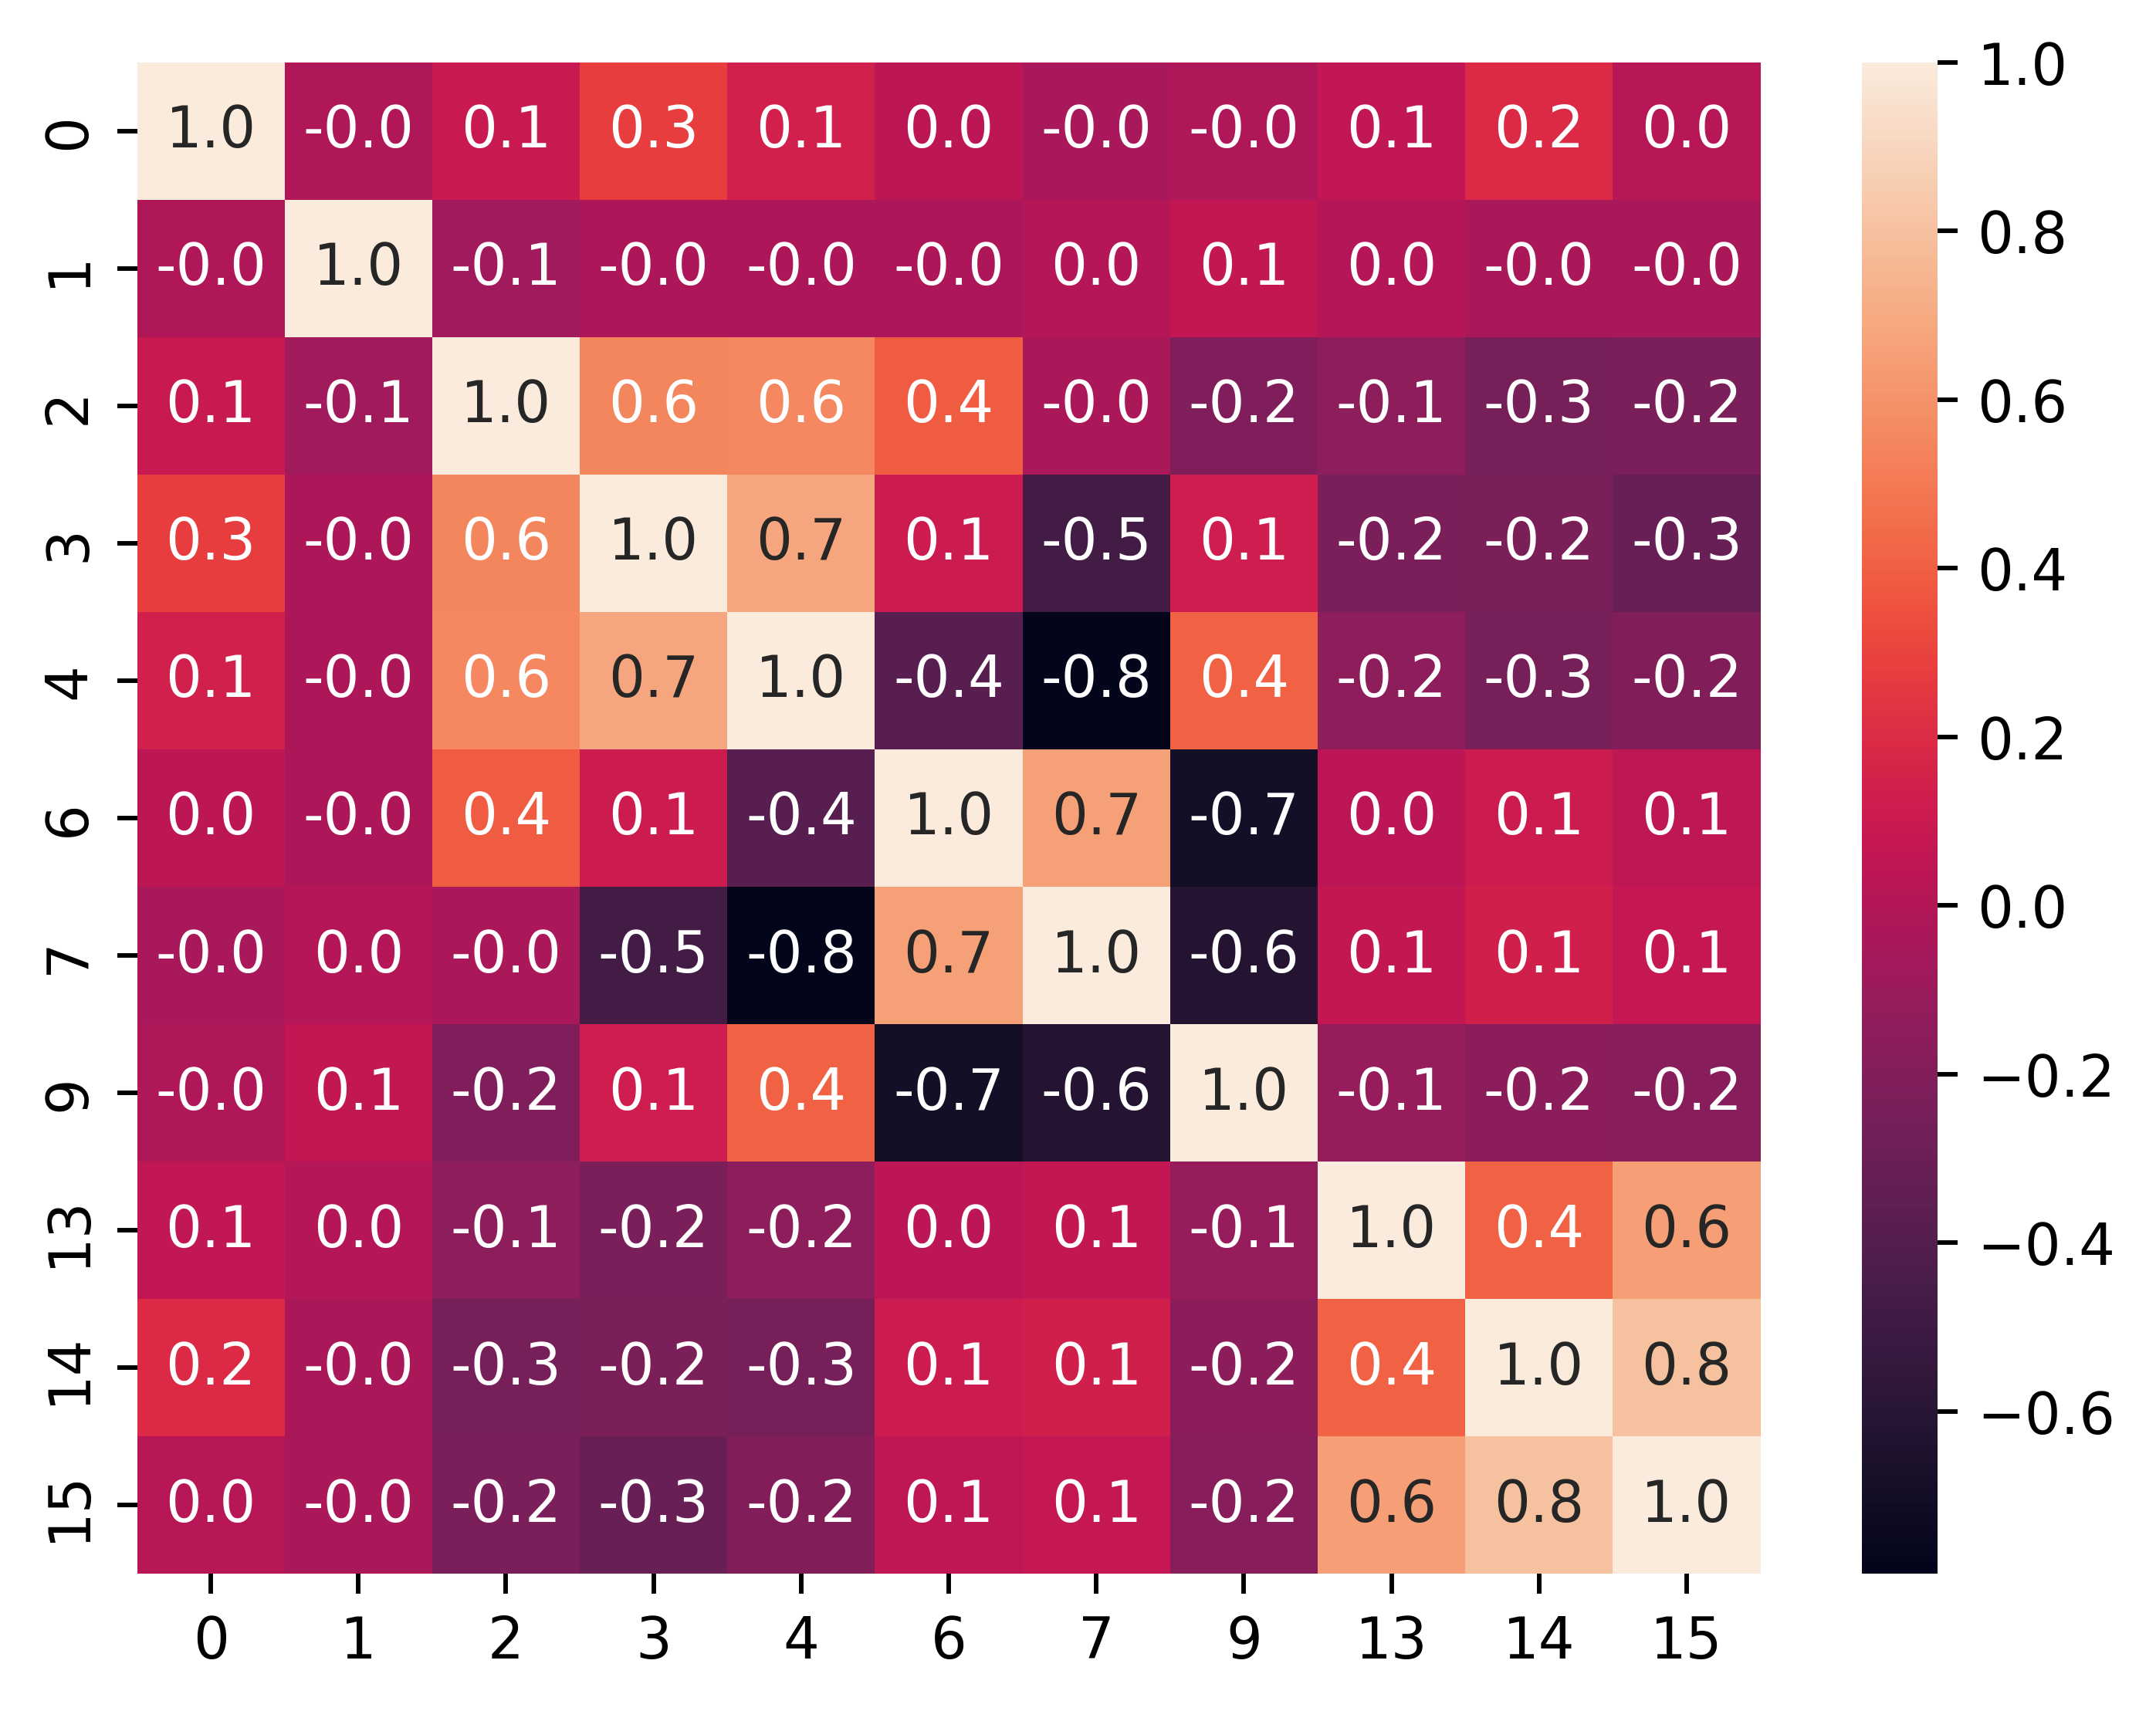

In [5]:
df=df.drop(columns=["8","5","10","11","12"])
corr = df.corr()
plt.figure(dpi=530)
sns.heatmap(df.corr(), annot=True, fmt= '.1f')
plt.show()


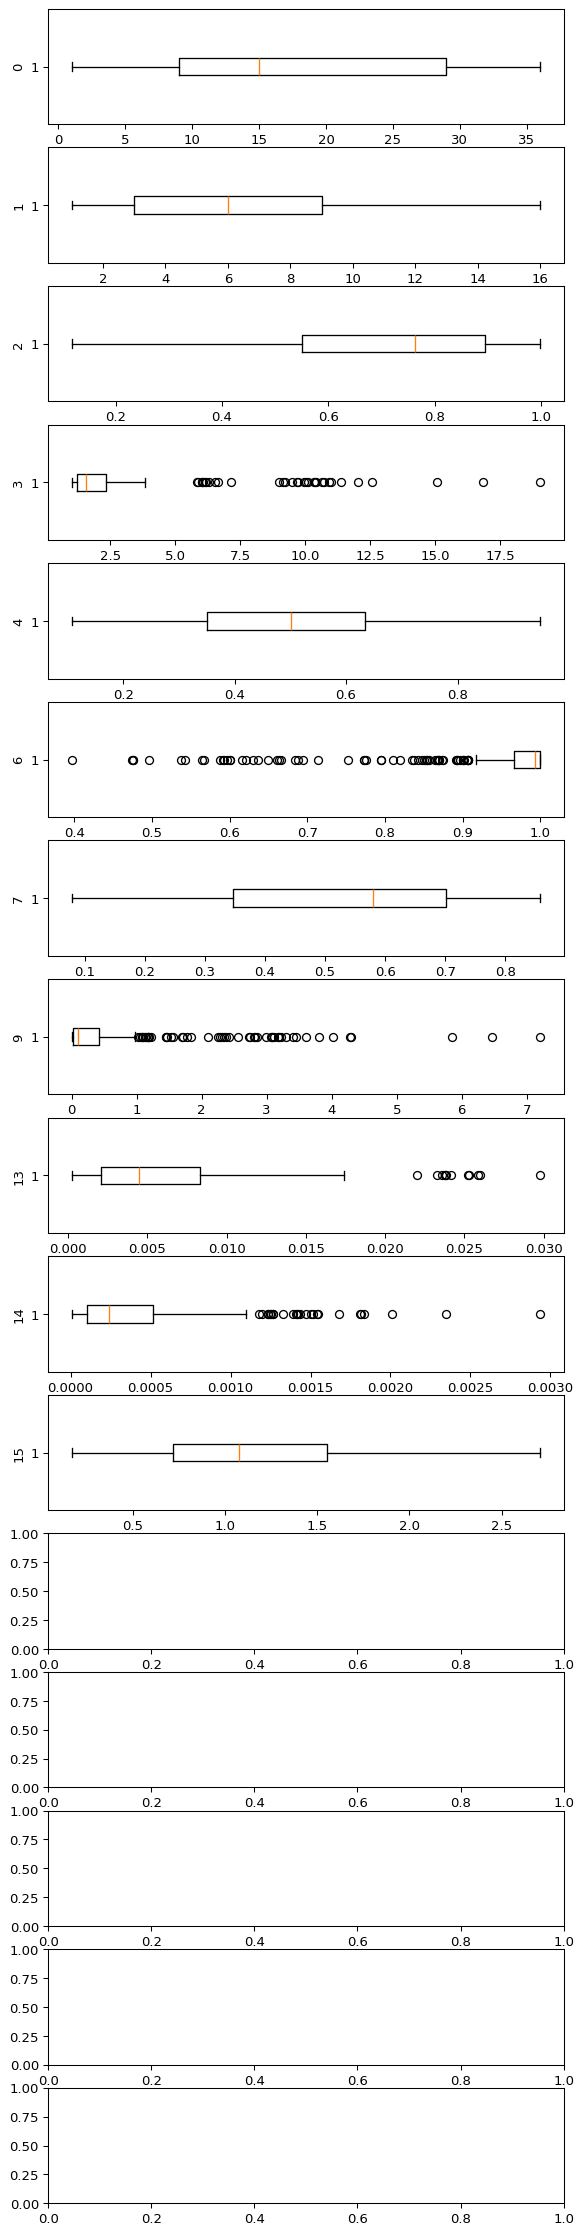

In [6]:
fig, axs = plt.subplots(16,1,dpi=95, figsize=(7,30))
i = 0
for col in df.columns:
    axs[i].boxplot(df[col], vert=False)
    axs[i].set_ylabel(col)
    i+=1
plt.show()

In [7]:
def get_number_of_folder(a):
    return int(a.split("\\")[1].split(".")[0])
folders = glob.glob('leaves\\*')
folders.sort(key=get_number_of_folder)
imagenames_list = []

for folder in folders[:15]:
    for f in glob.glob(folder+'/*.jpg'):
        imagenames_list.append(f)
for folder in folders[21:36]:
    for f in glob.glob(folder+'/*.jpg'):
        imagenames_list.append(f)
dsize = (128,128)        
read_images = []        
for image in imagenames_list:
    read_images.append(cv2.resize(cv2.imread(image, cv2.IMREAD_GRAYSCALE),dsize))

In [8]:
len(read_images)

340

In [9]:
# cv2.imshow("picture",read_images[0])
# cv2.waitKey(0)

In [10]:
def get_pixel(img, center, x, y):
    new_value = 0
    try:
        if img[x][y] >= center:
            new_value = 1
    except:
        pass
    return new_value

In [11]:
def lbp_calculated_pixel(img, x, y):
    center = img[x][y]
    val_ar = []
    val_ar.append(get_pixel(img, center, x - 1, y - 1))
    val_ar.append(get_pixel(img, center, x - 1, y))
    val_ar.append(get_pixel(img, center, x - 1, y + 1))
    val_ar.append(get_pixel(img, center, x, y + 1))
    val_ar.append(get_pixel(img, center, x + 1, y + 1))
    val_ar.append(get_pixel(img, center, x + 1, y))
    val_ar.append(get_pixel(img, center, x + 1, y - 1))
    val_ar.append(get_pixel(img, center, x, y - 1))
    power_val = [1, 2, 4, 8, 16, 32, 64, 128]
    val = 0
    for i in range(len(val_ar)):
        val += val_ar[i] * power_val[i]
    return val

In [12]:
def get_lbp(image):
    img_gray = image.copy()
    height, width= img_gray.shape
    img_lbp = np.zeros((height, width),
                       np.uint8)
    for i in range(0, height):
        for j in range(0, width):
            img_lbp[i, j] = lbp_calculated_pixel(img_gray, i, j)

    return img_lbp
def get_hog(image):
    fd, hog_image = hog(image, orientations=8, pixels_per_cell=(16, 16),cells_per_block=(1, 1), visualize=True)
    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))
    return hog_image_rescaled , fd

In [13]:
canny_feature=[]
lbp_feature=[]
hog_feature=[]
for image in read_images:
    # canny_feature.append(cv2.Canny(image,100,200).flatten())
    # lbp_feature.append(get_lbp(image).flatten())
    hog_pic,_=get_hog(image)
    hog_feature.append(hog_pic.flatten())

In [14]:
# features = np.concatenate(( np.array(hog_feature),np.array(lbp_feature)), axis=-1)
# # features.shape

In [15]:
X=pd.concat([X, pd.DataFrame(np.array(hog_feature))], axis=1)

In [16]:
X.shape

(340, 16399)

In [17]:

X.columns = X.columns.astype(str)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42)


In [19]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [20]:
pca=PCA(.95)
pca.fit(X_train)
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

In [21]:
# lda = LinearDiscriminantAnalysis(n_components=29)
# X_train = lda.fit_transform(X_train, y_train)
# X_test = lda.transform(X_test)

In [22]:
X_train.shape

(272, 133)

In [23]:
X_test.shape

(68, 133)

In [24]:
model = KMeans(n_clusters=30, random_state=42) 
leaves_Kmeans = model.fit(X_train)

C:\Users\mahboub\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\mahboub\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\mahboub\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\mahboub\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close

In [25]:
leaves_Kmeans.labels_

array([29, 27, 13, 12,  2,  3,  3, 16, 17, 13, 23, 17, 17,  6, 23,  3, 17,
       23, 17, 16, 12,  3,  3,  3,  4, 25, 17, 13, 23,  3, 16, 18, 13, 17,
       18, 29, 17,  3, 14, 17, 17, 23, 23, 28,  1, 23, 23,  3, 23, 23,  3,
       17, 13,  3, 17, 13, 23, 13,  3, 23,  2,  3, 29, 22, 23, 13, 23, 17,
        3, 21, 13,  7, 13, 29, 13, 29,  0, 29, 26, 23,  1, 17, 13, 23, 13,
       23, 13, 17, 23, 11, 29,  3, 23, 29, 29, 23, 13, 13, 27, 23, 23,  0,
       16,  2,  3,  3,  5, 13, 23, 17, 23, 23,  0, 13, 23, 27, 23, 13,  1,
       16, 13, 23, 13, 20, 13, 13,  1, 13,  2, 17, 16, 29, 23, 23, 13, 16,
       17,  1, 29,  3, 19, 23,  2, 10, 16, 17,  7, 23, 23,  3,  0, 17, 17,
       26, 13, 17, 17, 24, 17, 13, 23, 13, 13, 13,  2,  7, 17, 13, 13, 13,
        4,  7, 13,  7, 29,  1, 13, 17,  3,  3, 16, 13, 24, 13,  3, 29,  6,
        2, 23,  8, 13, 17,  1, 15,  1, 23, 13, 23, 17, 17, 16, 18, 23, 13,
        3, 17,  4, 16, 23, 11, 16,  3, 13, 17, 17, 23, 13, 23,  7, 23, 13,
        3, 16, 13,  3,  3

In [26]:
conf_matrix=confusion_matrix(y_train, leaves_Kmeans.labels_) 

In [27]:
# fig, ax = plt.subplots(figsize=(30, 30))
# ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
# for i in range(conf_matrix.shape[0]):
#     for j in range(conf_matrix.shape[1]):
#         ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', 
#                 ha='center', size='xx-large')
 
# plt.xlabel('Predictions', fontsize=18)
# plt.ylabel('Actuals', fontsize=18)
# plt.title('Confusion Matrix', fontsize=18)
# plt.show()

In [28]:
conf_matrix=confusion_matrix(y_test, leaves_Kmeans.predict(X_test)) 

In [29]:
# fig, ax = plt.subplots(figsize=(30, 30))
# ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
# for i in range(conf_matrix.shape[0]):
#     for j in range(conf_matrix.shape[1]):
#         ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', 
#                 ha='center', size='xx-large')
 
# plt.xlabel('Predictions', fontsize=18)
# plt.ylabel('Actuals', fontsize=18)
# plt.title('Confusion Matrix', fontsize=18)
# plt.show()

In [56]:
accuracy_score(y_test, leaves_Kmeans.predict(X_test))

0.0

In [57]:
plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}
def plot_clusters(data, algorithm, args, kwds):
    start_time = time.time()
    labels = algorithm(*args, **kwds).fit_predict(data)
    end_time = time.time()
    palette = sns.color_palette('deep', np.unique(labels).max() + 1)
    colors = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in labels]
    plt.scatter(data.T[0], data.T[1], c=colors, **plot_kwds)
    frame = plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)
    plt.title('Clusters found by {}'.format(str(algorithm.__name__)), fontsize=24)
    plt.text(-0.5, 0.7, 'Clustering took {:.2f} s'.format(end_time - start_time), fontsize=14)

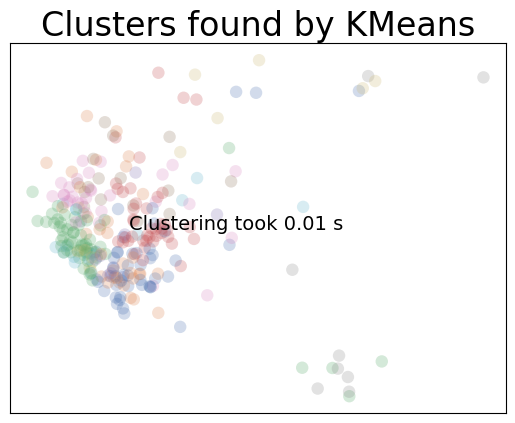

In [58]:
plot_clusters(X_train, cluster.KMeans, (), {'n_clusters':30})

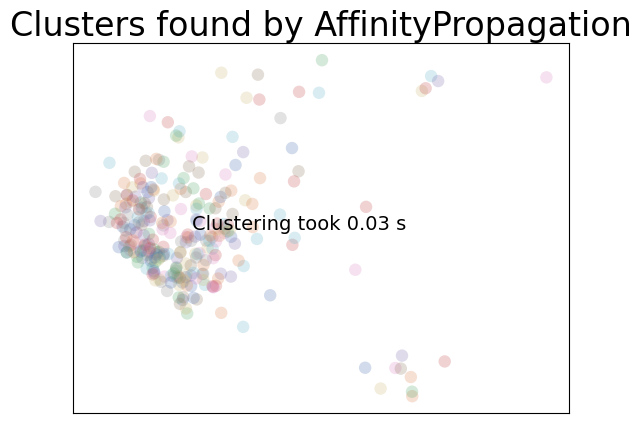

In [59]:
plot_clusters(X_train, cluster.AffinityPropagation, (), {'preference':-5.0, 'damping':0.95})

In [60]:
plot_clusters(X_train, cluster.MeanShift, (0.175,), {'cluster_all':False})

TypeError: MeanShift.__init__() takes 1 positional argument but 2 positional arguments (and 1 keyword-only argument) were given

C:\Users\mahboub\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
C:\Users\mahboub\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\mahboub\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:187: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
C:\Users\mahboub\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:208: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
C:\Users\mahboub\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\pairwise.py:397: RuntimeWarning: invalid value encountered in add
  distances += XX
C:\Users\mahboub\AppData\Local\P

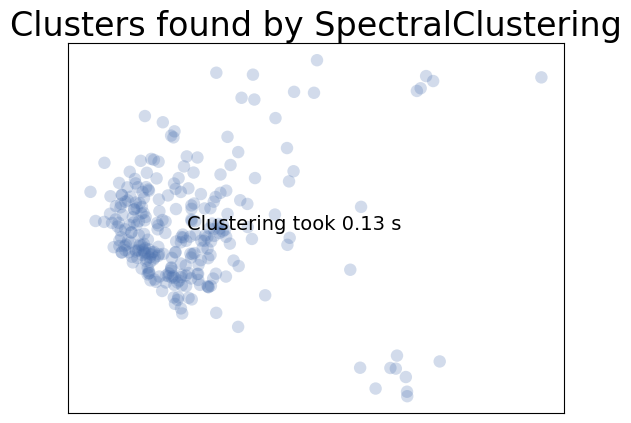

In [61]:
plot_clusters(X_train, cluster.SpectralClustering, (), {'n_clusters':30})

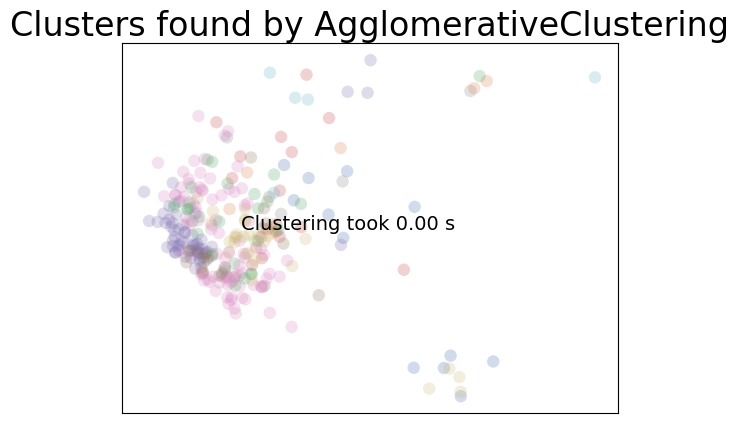

In [62]:
plot_clusters(X_train, cluster.AgglomerativeClustering, (), {'n_clusters':30, 'linkage':'ward'})

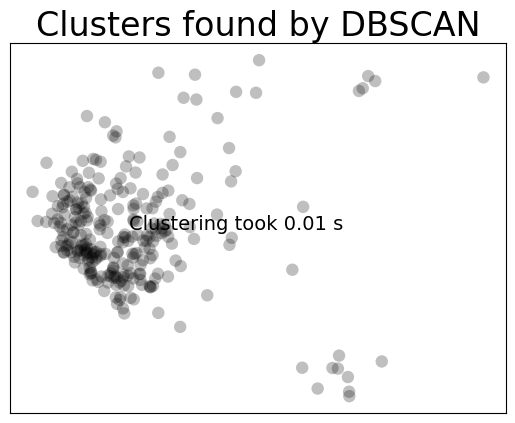

In [63]:
plot_clusters(X_train, cluster.DBSCAN, (), {'eps':0.025,})

In [72]:
plot_clusters(X_train, hdbscan.HDBSCAN, (), {'min_cluster_size':30})

AttributeError: 'HDBSCAN' object has no attribute 'HDBSCAN'

In [65]:
gnb = GaussianNB().fit(X_train, y_train) 
gnb_predictions = gnb.predict(X_test) 
accuracy = gnb.score(X_test, y_test) 
accuracy_score(y_test, gnb_predictions)


0.6029411764705882

In [66]:
clf = OneVsRestClassifier(SVC()).fit(X_train, y_train)
y_pred_clf=clf.predict(X_test)
accuracy_score(y_test, y_pred_clf)

0.7647058823529411

In [67]:
svm_model_linear = SVC(kernel = 'linear', C = 1).fit(X_train, y_train) 
svm_predictions = svm_model_linear.predict(X_test) 
accuracy_score(y_test, svm_predictions)

0.7794117647058824

In [68]:
rbf_svm=SVC(kernel='poly', degree=1, C=1).fit(X_train,y_train)
rbf_svm_prediction=rbf_svm.predict(X_test)
accuracy_score(y_test, rbf_svm_prediction)

0.6029411764705882

In [69]:
model = DecisionTreeClassifier()       
model.fit(X_train, y_train)             
y_pred = model.predict(X_test)
accuracy_score(y_test, y_pred)

0.4117647058823529

In [70]:
classifier = RandomForestClassifier(max_depth=2,
                                    random_state=0)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
accuracy_score(y_test, y_pred)

0.5